In [1]:
from SimPEG import EM, Mesh, Utils, Maps, Survey
from SimPEG import DataMisfit, Regularization, Optimization, InvProblem, Directives, Inversion
# from SimPEG.EM.Static import DC
from SimPEG.EM import FDEM, mu_0
import numpy as np
from pymatsolver import PardisoSolver

# from ipywidgets import interact, IntSlider
%pylab inline
%matplotlib notebook
# %matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 14

from itertools import combinations
from matplotlib import gridspec

# import plotly
# import plotly.graph_objs as go

import time
# import sys
# sys.path.append("./utilcodes/")
# from vizutils import viz, gettopoCC, vizEJ
import pickle


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Mesh
mesh = Mesh.TensorMesh.readUBC('./StraightTunnel_MultiBlk_TensorCore.msh')
print(mesh.nC)

# Load True Block model
sigmaTrue = mesh.readModelUBC('./StraightTunnel_MultiBlk_TensorCore.mod')
print(sigmaTrue.shape)


183229
(183229,)


In [3]:
def line(a, t, l):
    """
        Linear interpolation between a and b
        0 <= t <= 1
    """
    return a + t * l

In [4]:
def weight(t, a1, l1, h1, a2, l2, h2):
    """
        Edge basis functions
    """
    x1 = line(a1, t, l1)
    x2 = line(a2, t, l2)
    w0 = (1. - x1 / h1) * (1. - x2 / h2)
    w1 = (x1 / h1) * (1. - x2 / h2)
    w2 = (1. - x1 / h1) * (x2 / h2)
    w3 = (x1 / h1) * (x2 / h2)
    return np.r_[w0, w1, w2, w3]


In [5]:
# TODO: Extend this when current is defined on cell-face
def getStraightLineCurrentIntegral(hx, hy, hz, ax, ay, az, bx, by, bz):
    """
      Compute integral int(W . J dx^3) in brick of size hx x hy x hz
      where W denotes the 12 local bilinear edge basis functions
      and where J prescribes a unit line current
      between points (ax,ay,az) and (bx,by,bz).
    """

    # length of line segment
    lx = bx - ax
    ly = by - ay
    lz = bz - az
    l = np.sqrt(lx**2+ly**2+lz**2)

    if l == 0:
        sx = np.zeros(4, 1)
        sy = np.zeros(4, 1)
        sz = np.zeros(4, 1)

    # integration using Simpson's rule
    wx0 = weight(0., ay, ly, hy, az, lz, hz)
    wx0_5 = weight(0.5, ay, ly, hy, az, lz, hz)
    wx1 = weight(1., ay, ly, hy, az, lz, hz)

    wy0 = weight(0., ax, lx, hx, az, lz, hz)
    wy0_5 = weight(0.5, ax, lx, hx, az, lz, hz)
    wy1 = weight(1., ax, lx, hx, az, lz, hz)

    wz0 = weight(0., ax, lx, hx, ay, ly, hy)
    wz0_5 = weight(0.5, ax, lx, hx, ay, ly, hy)
    wz1 = weight(1., ax, lx, hx, ay, ly, hy)

    sx = (wx0 + 4. * wx0_5 + wx1) * (lx / 6.)

    sy = (wy0 + 4. * wy0_5 + wy1) * (ly / 6.)
    sz = (wz0 + 4. * wz0_5 + wz1) * (lz / 6.)

    return sx, sy, sz



In [6]:
def findlast(x):
    if x.sum() == 0:
        return -1
    else:
        return np.arange(x.size)[x][-1]

In [7]:
# Test code which is meant to simply the getSourceTermLineCurrentPolygon function (SimPEG/EM/Utils/CurrentUtils.py)
# for a single segment of wire between 2 points, A and B.

hx = mesh.hx
hy = mesh.hy
hz = mesh.hz

nx = len(hx)
ny = len(hy)
nz = len(hz)

xorig = mesh.x0
x0, y0, z0 = xorig[0], xorig[1], xorig[2]

# nodal grid
x = np.r_[x0, x0+np.cumsum(hx)]
y = np.r_[y0, y0+np.cumsum(hy)]
z = np.r_[z0, z0+np.cumsum(hz)]

# discrete edge function
sx = np.zeros((nx, ny+1, nz+1))
sy = np.zeros((nx+1, ny, nz+1))
sz = np.zeros((nx+1, ny+1, nz))

# Test points A and B which will be connected with the current wire path
# A = np.array([5.25, 0.45, 2.15])
# ax = A[0]
# ay = A[1]
# az = A[2]

# B = np.array([5.25, 0.45, 2.35])
# bx = B[0]
# by = B[1]
# bz = B[2]

A = np.array([5., 0., 2.])
ax = A[0]
ay = A[1]
az = A[2]

B = np.array([15., 7., 3.])
bx = B[0]
by = B[1]
bz = B[2]

# find intersection with mesh planes
dx = bx - ax
dy = by - ay
dz = bz - az
d = np.sqrt(dx**2+dy**2+dz**2)

tol = d * np.finfo(float).eps

if abs(dx) > tol:
    tx = (x - ax) / dx
    tx = tx[np.logical_and(tx >= 0, tx <= 1)]
else:
    tx = []

if abs(dy) > tol:
    ty = (y - ay) / dy
    ty = ty[np.logical_and(ty >= 0, ty <= 1)]
else:
    ty = []

if abs(dz) > tol:
    tz = (z - az) / dz
    tz = tz[np.logical_and(tz >= 0, tz <= 1)]
else:
    tz = []

t = np.unique(np.r_[0., tx, ty, tz, 1.])
print('t=', t)
print(t.shape)
nq = len(t) - 1
print('nq=', nq)
# print(len(t[:nq]))
# print(len(t[1:nq+1]))
tc = 0.5 * (t[:nq] + t[1:nq+1])
print('tc =', tc)

for iq in range(nq):

    cx = ax + tc[iq] * dx
#     print('cx =', cx)
    cy = ay + tc[iq] * dy
#     print('cy =', cy)
    cz = az + tc[iq] * dz
    print('(cx, cy, cz) =', cx, cy, cz)

    # locate cell id

    ix = findlast(np.logical_and(cx >= x[:nx-1], cx <= x[1:nx]))
    iy = findlast(np.logical_and(cy >= y[:ny-1], cy <= y[1:ny]))
    iz = findlast(np.logical_and(cz >= z[:nz-1], cz <= z[1:nz]))
    print('(ix, iy, iz) =', ix, iy, iz)

    # local coordinates
    hxloc = hx[ix]
    hyloc = hy[iy]
    hzloc = hz[iz]
    print('(hxloc, hyloc, hzloc) =', hxloc, hyloc, hzloc)
    axloc = ax + t[iq]   * dx - x[ix]
    ayloc = ay + t[iq]   * dy - y[iy]
    azloc = az + t[iq]   * dz - z[iz]
    print('(axloc, ayloc, azloc) =', axloc, ayloc, azloc)
    bxloc = ax + t[iq+1] * dx - x[ix]
    byloc = ay + t[iq+1] * dy - y[iy]
    bzloc = az + t[iq+1] * dz - z[iz]
    print('(bxloc, byloc, bzloc) =', bxloc, byloc, bzloc)
    
        # integrate
    sxloc, syloc, szloc = getStraightLineCurrentIntegral(hxloc, hyloc,
                                                         hzloc, axloc,
                                                         ayloc, azloc,
                                                         bxloc, byloc,
                                                         bzloc)
    print('(sxloc, syloc, szloc) =', sxloc, syloc, szloc)
    # integrate
    sx[ix, iy:iy+2, iz:iz+2] += np.reshape(sxloc, (2, 2), order="F")
    print(ix)
    print(iy,iy+2)
    print(iz,iz+2)
    print(sx[ix, iy:iy+2, iz:iz+2])
    print(np.reshape(sxloc, (2, 2), order="F"))
    sy[ix:ix+2, iy, iz:iz+2] += np.reshape(syloc, (2, 2), order="F")
    sz[ix:ix+2, iy:iy+2, iz] += np.reshape(szloc, (2, 2), order="F")

Src = np.r_[Utils.mkvc(sx), Utils.mkvc(sy), Utils.mkvc(sz)]


t= [0.         0.05       0.07142857 0.15       0.21428571 0.25
 0.35       0.35714286 0.45       0.5        0.55       0.64285714
 0.65       0.75       0.78571429 0.85       0.92857143 0.95
 1.        ]
(19,)
nq= 18
tc = [0.025      0.06071429 0.11071429 0.18214286 0.23214286 0.3
 0.35357143 0.40357143 0.475      0.525      0.59642857 0.64642857
 0.7        0.76785714 0.81785714 0.88928571 0.93928571 0.975     ]
(cx, cy, cz) = 5.25 0.17500000000000002 2.025
(ix, iy, iz) = 34 20 22
(hxloc, hyloc, hzloc) = 1.0 1.0 1.0
(axloc, ayloc, azloc) = 0.5 0.5 0.5
(bxloc, byloc, bzloc) = 1.0 0.8500000000000001 0.5499999999999998
(sxloc, syloc, szloc) = [0.07791667 0.15958333 0.08458333 0.17791667] [0.04229167 0.12395833 0.04520833 0.13854167] [0.00479167 0.01145833 0.00770833 0.02604167]
34
20 22
22 24
[[0.07791667 0.08458333]
 [0.15958333 0.17791667]]
[[0.07791667 0.08458333]
 [0.15958333 0.17791667]]
(cx, cy, cz) = 5.607142857142857 0.425 2.0607142857142855
(ix, iy, iz) = 35 20 22
(hxloc, hyloc

In [8]:
print(Src.shape)
SrcInd = np.where(Src)[0]
print(SrcInd)
print(Src[SrcInd])
print(len(SrcInd))
print(len(SrcInd)/4)

(571116,)
[102930 102931 103039 103040 103041 103149 103150 103151 103152 103259
 103260 103261 103262 103370 103371 107508 107509 107617 107618 107619
 107727 107728 107729 107730 107837 107838 107839 107840 107948 107949
 107950 108058 108059 108060 108061 108168 108169 108170 108171 108279
 108280 108281 108389 108390 112527 112528 112636 112637 112638 112639
 112746 112747 112748 112749 112857 112858 112859 112967 112968 293730
 293731 293732 293841 293842 293843 293952 293953 293954 293955 294064
 294065 294066 298240 298241 298242 298351 298352 298353 298462 298463
 298464 298465 298574 298575 298576 298685 298686 298687 298796 298797
 298798 298799 298908 298909 298910 299019 299020 299021 303195 303196
 303197 303306 303307 303308 303309 303418 303419 303420 303529 303530
 303531 485570 485571 485572 485680 485681 485682 485683 485791 485792
 485793 485794 485795 485902 485903 485904 485905 485906 486014 486015
 486016 490635 490636 490637 490745 490746 490747 490748 490749 490

In [9]:
print(mesh.nE)
print(mesh.nEx)
print(mesh.nEy)
print(mesh.nEz)

ExInd = SrcInd[SrcInd <= mesh.nEx]
print('ExInd=', ExInd)
EyInd = SrcInd[np.all(np.vstack([mesh.nEx <= SrcInd, SrcInd <= (mesh.nEx + mesh.nEy)]).T, axis=1)] - mesh.nEx
print('EyInd=', EyInd)
EzInd = SrcInd[np.all(np.vstack([(mesh.nEx + mesh.nEy) <= SrcInd, SrcInd <= mesh.nE]).T, axis=1)] - (mesh.nEx + mesh.nEy)
print('EzInd=', EzInd)

srcX_Value = sx[np.where(sx != 0)]
print(srcX_Value)
srcY_Value = sy[np.where(sy != 0)]
print(srcY_Value)
srcZ_Value = sz[np.where(sz != 0)]
print(srcZ_Value)

571116
192276
189420
189420
ExInd= [102930 102931 103039 103040 103041 103149 103150 103151 103152 103259
 103260 103261 103262 103370 103371 107508 107509 107617 107618 107619
 107727 107728 107729 107730 107837 107838 107839 107840 107948 107949
 107950 108058 108059 108060 108061 108168 108169 108170 108171 108279
 108280 108281 108389 108390 112527 112528 112636 112637 112638 112639
 112746 112747 112748 112749 112857 112858 112859 112967 112968]
EyInd= [101454 101455 101456 101565 101566 101567 101676 101677 101678 101679
 101788 101789 101790 105964 105965 105966 106075 106076 106077 106186
 106187 106188 106189 106298 106299 106300 106409 106410 106411 106520
 106521 106522 106523 106632 106633 106634 106743 106744 106745 110919
 110920 110921 111030 111031 111032 111033 111142 111143 111144 111253
 111254 111255]
EzInd= [103874 103875 103876 103984 103985 103986 103987 104095 104096 104097
 104098 104099 104206 104207 104208 104209 104210 104318 104319 104320
 108939 108940 108

In [10]:
def plotGrid_Src(
    mesh, ax=None, nodes=False, nodeInd=[], faces=False, FxInd=[], FyInd=[], FzInd=[], centers=False, CCInd=[], 
    edges=False, ExInd=[], EyInd=[], EzInd=[], lines=True, showIt=False,):
    """Plot the nodal, cell-centered and staggered grids for 1,2 and 3 dimensions.

    :param bool nodes: plot nodes
    :param bool faces: plot faces
    :param bool centers: plot centers
    :param bool edges: plot edges
    :param bool lines: plot lines connecting nodes
    :param bool showIt: call plt.show()

    .. plot::
       :include-source:

       import discretize
       import numpy as np
       h1 = np.linspace(.1, .5, 3)
       h2 = np.linspace(.1, .5, 5)
       mesh = discretize.TensorMesh([h1, h2])
       mesh.plotGrid(nodes=True, faces=True, centers=True, lines=True, showIt=True)

    .. plot::
       :include-source:

       import discretize
       import numpy as np
       h1 = np.linspace(.1, .5, 3)
       h2 = np.linspace(.1, .5, 5)
       h3 = np.linspace(.1, .5, 3)
       mesh = discretize.TensorMesh([h1, h2, h3])
       mesh.plotGrid(nodes=True, faces=True, centers=True, lines=True, showIt=True)

    """

    axOpts = {'projection': '3d'} if mesh.dim == 3 else {}
    if ax is None:
        plt.figure(figsize=[12.4, 10.8])
        ax = plt.subplot(111, **axOpts)
    else:
        if not isinstance(ax, matplotlib.axes.Axes):
            raise AssertionError("ax must be an matplotlib.axes.Axes")

#         if mesh.dim == 1:
#             if nodes:
#                 ax.plot(
#                     mesh.gridN, np.ones(mesh.nN), color="C0", marker="s",
#                     linestyle=""
#                 )
#             if centers:
#                 ax.plot(
#                     mesh.gridCC, np.ones(mesh.nC), color="C1", marker="o",
#                     linestyle=""
#                 )
#             if lines:
#                 ax.plot(
#                     mesh.gridN, np.ones(mesh.nN), color="C0", linestyle="-"
#                 )
#             ax.set_xlabel('x1')
#         elif mesh.dim == 2:
#             if nodes:
#                 ax.plot(
#                     mesh.gridN[:, 0], mesh.gridN[:, 1], color="C0", marker="s",
#                     linestyle=""
#                 )
#             if centers:
#                 ax.plot(
#                     mesh.gridCC[:, 0], mesh.gridCC[:, 1], color="C1",
#                     marker="o", linestyle=""
#                 )
#             if faces:
#                 ax.plot(
#                     mesh.gridFx[:, 0], mesh.gridFx[:, 1], color="C2",
#                     marker=">", linestyle=""
#                 )
#                 ax.plot(
#                     mesh.gridFy[:, 0], mesh.gridFy[:, 1], color="C2",
#                     marker="^", linestyle=""
#                 )
#             if edges:
#                 ax.plot(
#                     mesh.gridEx[:, 0], mesh.gridEx[:, 1], color="C3",
#                     marker=">", linestyle=""
#                 )
#                 ax.plot(
#                     mesh.gridEy[:, 0], mesh.gridEy[:, 1], color="C3",
#                     marker="^", linestyle=""
#                 )

#             color = kwargs.get('color', 'C0')
#             linewidth = kwargs.get('linewidth', 1.)
#             # Plot the grid lines
#             if lines:
#                 NN = mesh.r(mesh.gridN, 'N', 'N', 'M')
#                 X1 = np.c_[Utils.mkvc(NN[0][0, :]), Utils.mkvc(NN[0][mesh.nCx, :]), Utils.mkvc(NN[0][0, :])*np.nan].flatten()
#                 Y1 = np.c_[Utils.mkvc(NN[1][0, :]), Utils.mkvc(NN[1][mesh.nCx, :]), Utils.mkvc(NN[1][0, :])*np.nan].flatten()
#                 X2 = np.c_[Utils.mkvc(NN[0][:, 0]), Utils.mkvc(NN[0][:, mesh.nCy]), Utils.mkvc(NN[0][:, 0])*np.nan].flatten()
#                 Y2 = np.c_[Utils.mkvc(NN[1][:, 0]), Utils.mkvc(NN[1][:, mesh.nCy]), Utils.mkvc(NN[1][:, 0])*np.nan].flatten()
#                 X = np.r_[X1, X2]
#                 Y = np.r_[Y1, Y2]
#                 ax.plot(X, Y, color=color, linestyle="-", lw=linewidth)

#             ax.set_xlabel('x1')
#             ax.set_ylabel('x2')
    if mesh.dim == 3:
        if nodes:
            ax.plot(
                mesh.gridN[nodeInd, 0], mesh.gridN[nodeInd, 1], color="C0", marker="s",
                linestyle="", zs=mesh.gridN[nodeInd, 2]
            )
        if centers:
            ax.plot(
                mesh.gridCC[CCInd, 0], mesh.gridCC[CCInd, 1], color="C1",
                marker="o", linestyle="", zs=mesh.gridCC[CCInd, 2]
            )
        if faces:
            ax.plot(
                mesh.gridFx[FxInd, 0], mesh.gridFx[FxInd, 1], color="C2",
                marker=">", linestyle="", zs=mesh.gridFx[FxInd, 2]
            )
            ax.plot(
                mesh.gridFy[FyInd, 0], mesh.gridFy[FyInd, 1], color="C3",
                marker="<", linestyle="", zs=mesh.gridFy[FyInd, 2]
            )
            ax.plot(
                mesh.gridFz[FzInd, 0], mesh.gridFz[FzInd, 1], color="C4",
                marker="^", linestyle="", zs=mesh.gridFz[FzInd, 2]
            )
        if edges:
            ax.scatter(mesh.gridEx[ExInd, 0], mesh.gridEx[ExInd, 1], mesh.gridEx[ExInd, 2],
                c="C5" , s=1000*srcX_Value, marker=">"
            )
            ax.scatter(mesh.gridEy[EyInd, 0], mesh.gridEy[EyInd, 1], mesh.gridEy[EyInd, 2],
                c="C6" , s=1000*srcY_Value, marker="<"
            )
            ax.scatter(mesh.gridEz[EzInd, 0], mesh.gridEz[EzInd, 1], mesh.gridEz[EzInd, 2],
                c="C7" , s=1000*srcZ_Value, marker="^"
            )
#             ax.scatter(
#                 mesh.gridEx[ExInd, 0], mesh.gridEx[ExInd, 1], color="C5",
#                 marker=">", linestyle="", zs=mesh.gridEx[ExInd, 2]
#             )
#             ax.scatter(
#                 mesh.gridEy[EyInd, 0], mesh.gridEy[EyInd, 1], color="C6",
#                 marker="<", linestyle="", zs=mesh.gridEy[EyInd, 2]
#             )
#             ax.scatter(
#                 mesh.gridEz[EzInd, 0], mesh.gridEz[EzInd, 1], color="C7",
#                 marker="^", linestyle="", zs=mesh.gridEz[EzInd, 2]
#             )

        # Plot the grid lines
        if lines:
            NN = mesh.r(mesh.gridN, 'N', 'N', 'M')
            X1 = np.c_[Utils.mkvc(NN[0][0, :, :]), Utils.mkvc(NN[0][mesh.nCx, :, :]), Utils.mkvc(NN[0][0, :, :])*np.nan].flatten()
            Y1 = np.c_[Utils.mkvc(NN[1][0, :, :]), Utils.mkvc(NN[1][mesh.nCx, :, :]), Utils.mkvc(NN[1][0, :, :])*np.nan].flatten()
            Z1 = np.c_[Utils.mkvc(NN[2][0, :, :]), Utils.mkvc(NN[2][mesh.nCx, :, :]), Utils.mkvc(NN[2][0, :, :])*np.nan].flatten()
            X2 = np.c_[Utils.mkvc(NN[0][:, 0, :]), Utils.mkvc(NN[0][:, mesh.nCy, :]), Utils.mkvc(NN[0][:, 0, :])*np.nan].flatten()
            Y2 = np.c_[Utils.mkvc(NN[1][:, 0, :]), Utils.mkvc(NN[1][:, mesh.nCy, :]), Utils.mkvc(NN[1][:, 0, :])*np.nan].flatten()
            Z2 = np.c_[Utils.mkvc(NN[2][:, 0, :]), Utils.mkvc(NN[2][:, mesh.nCy, :]), Utils.mkvc(NN[2][:, 0, :])*np.nan].flatten()
            X3 = np.c_[Utils.mkvc(NN[0][:, :, 0]), Utils.mkvc(NN[0][:, :, mesh.nCz]), Utils.mkvc(NN[0][:, :, 0])*np.nan].flatten()
            Y3 = np.c_[Utils.mkvc(NN[1][:, :, 0]), Utils.mkvc(NN[1][:, :, mesh.nCz]), Utils.mkvc(NN[1][:, :, 0])*np.nan].flatten()
            Z3 = np.c_[Utils.mkvc(NN[2][:, :, 0]), Utils.mkvc(NN[2][:, :, mesh.nCz]), Utils.mkvc(NN[2][:, :, 0])*np.nan].flatten()
            X = np.r_[X1, X2, X3]
            Y = np.r_[Y1, Y2, Y3]
            Z = np.r_[Z1, Z2, Z3]
            ax.plot(X, Y, color="C0", linestyle="-", zs=Z)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
    else:
        print('Not implemented for 1 or 2D cases.')

    ax.grid(True)
    if showIt:
        plt.show()

    return ax

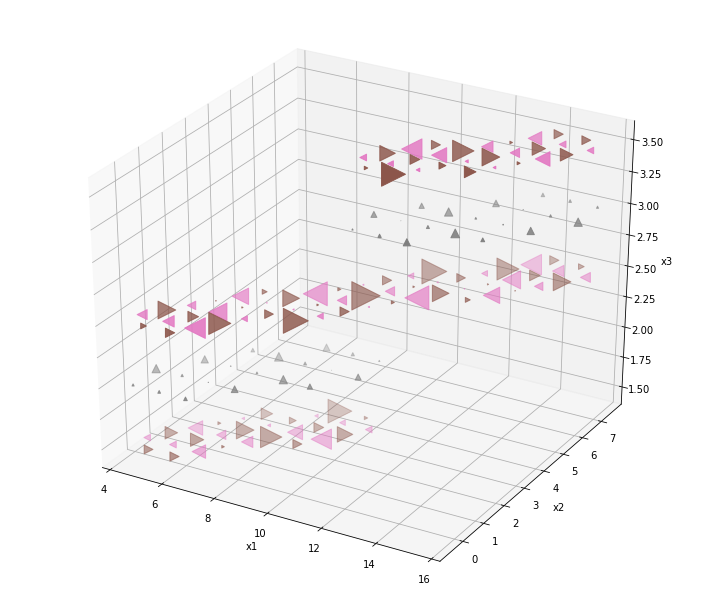

In [11]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
plotGrid_Src(mesh, edges=True, ExInd=ExInd, EyInd=EyInd, EzInd=EzInd, lines=False, showIt=True)